# Transfer Learning 
:: 학습된 model을 기반으로 output layer을 바꿔 학습하는 기법
- idea : 인간은 과거학습한 지식으로 새로운 문제를 풀수있다.
1. output layer을 보여중인 data에 대응하는 output layer로 바꾸기
2. 교체한 output layer을 소량의 data로 다시 학습 
> - 이때 input layer에 가까운 부분의 결합 파라미터는 학습된 값으로 변화 시키지 않는다.
>> - input layer에 가까운 층의 Parameter도 바꿔 학습된 값으로 갱신하는 방법은 Fine Tuning이라고한다.

:: Transfer Learning의 장점.
> 1. 적은 data set으로 학습이 가능
> 2. 시간 절약
> 3. 보통 전이학습 모델의 성능이 더 좋다.(초,중,후반 layer feture 추출이 다름)
>> ex) 이미지의 경우초,중반 layer에서는 직선,곡선의 대한 추출이기때문에 다른 글자인식에도 도움이된다.

---

## Transfer learning with VGGNet & MNIST Dataset

- Goal : 
> vgg16 model로 Tramsfer Learning을 이용하여 MNIST Data 학습시켜 확인해보자.
>> 즉, image net을 학습한 model이 MNIST의 숫자 data들을 잘 구별할수있나 확인해보자.

## Import Packages

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from torchvision import models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Transform & Data set

- image net input size: (3,224,224) 
- MINST input size : (1,28,28)

:: 위의 사이즈가 다르므로 Resize,lambda를 이용하여 MINST의 input size변경 

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.1,),(0.5,)),
                            transforms.Resize(224),
                             transforms.Lambda(lambda x: x.repeat(3,1,1))])

download_root = '/content/drive/MyDrive/Colab\ Notebooks/deep_learning_data'

# MNIST dataset
train_dataset = MNIST(download_root, transform=trans, train=True, download=True)
test_dataset = MNIST(download_root, transform=trans, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab\ Notebooks/deep_learning_data/MNIST/raw



In [ ]:
print(train_dataset.train_data.size())/
print(train_dataset.train_labels.size())

print(test_dataset.test_data.size())
print(test_dataset.test_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


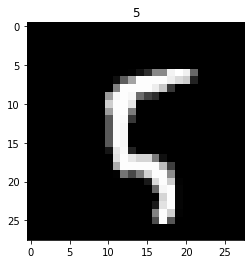

In [ ]:
plt.imshow(train_dataset.data[100], cmap='gray')
plt.title('%i' % train_dataset.targets[100])
plt.show()

In [ ]:
output_size = 10
batch_size = 256
num_epochs = 2
learning_rate = 1e-2

## DataLoader 작성

In [ ]:
train_dataloader = DataLoader(dataset= train_dataset,
                          batch_size= batch_size,
                          shuffle=True)

val_dataloader = DataLoader(dataset= test_dataset,
                          batch_size= batch_size)

dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader,
}


In [ ]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([256, 3, 224, 224])
tensor([4, 7, 6, 9, 4, 6, 9, 3, 9, 3, 1, 8, 3, 2, 6, 5, 9, 2, 4, 7, 8, 9, 0, 2,
        1, 3, 4, 5, 2, 8, 7, 6, 1, 3, 7, 5, 9, 7, 0, 4, 8, 1, 3, 7, 4, 7, 1, 2,
        8, 0, 5, 1, 5, 3, 9, 9, 4, 3, 5, 0, 9, 3, 4, 9, 9, 1, 7, 9, 9, 7, 4, 5,
        8, 1, 0, 5, 4, 8, 7, 9, 4, 4, 0, 3, 3, 6, 1, 6, 8, 3, 6, 0, 5, 5, 1, 7,
        4, 3, 7, 5, 4, 7, 8, 3, 9, 6, 5, 4, 0, 4, 5, 3, 0, 1, 8, 8, 9, 2, 0, 3,
        0, 2, 1, 4, 5, 3, 2, 8, 9, 7, 4, 6, 1, 4, 6, 8, 2, 8, 8, 6, 1, 5, 0, 6,
        4, 6, 6, 7, 1, 7, 3, 1, 8, 5, 0, 4, 2, 2, 7, 1, 8, 7, 5, 0, 6, 2, 4, 2,
        1, 6, 0, 7, 7, 5, 4, 3, 0, 2, 4, 0, 4, 0, 2, 6, 8, 4, 1, 1, 1, 7, 5, 0,
        5, 2, 5, 0, 3, 7, 3, 8, 8, 1, 8, 1, 9, 5, 5, 3, 5, 5, 3, 0, 8, 9, 1, 3,
        1, 9, 1, 9, 8, 5, 7, 0, 0, 2, 4, 1, 4, 0, 3, 5, 1, 0, 2, 8, 9, 3, 3, 3,
        8, 5, 5, 9, 1, 8, 2, 6, 9, 8, 9, 4, 8, 7, 9, 6])


## Network Model

- vgg16 model을 불러오고 classifier의 마지막 부분의 out features를 MNIST Data에 맞게 10으로 변경

In [ ]:
net = models.vgg16(pretrained=True)

print(net.classifier)

net.classifier[6] = nn.Linear(in_features=4096, out_features=10)

net = net.to(device)

net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
net.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

## Define of Loss Function 

In [ ]:
criterion = nn.CrossEntropyLoss()

## Training output layer

In [ ]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print("--------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
--------------
[Parameter containing:
tensor([[-0.0117,  0.0020,  0.0101,  ..., -0.0047, -0.0109,  0.0133],
        [-0.0034,  0.0043, -0.0039,  ..., -0.0049, -0.0144, -0.0130],
        [-0.0134,  0.0137, -0.0066,  ...,  0.0053,  0.0074, -0.0094],
        ...,
        [ 0.0100,  0.0057,  0.0149,  ..., -0.0065,  0.0078, -0.0032],
        [-0.0152, -0.0056,  0.0002,  ...,  0.0153, -0.0038,  0.0127],
        [ 0.0074, -0.0040, -0.0150,  ..., -0.0083, -0.0057,  0.0081]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0054,  0.0048, -0.0049,  0.0153,  0.0021, -0.0102,  0.0096, -0.0105,
         0.0046, -0.0069], device='cuda:0', requires_grad=True)]


## Define of Optimization

In [ ]:
optimizer = optim.SGD(params=params_to_update, lr=0.01, momentum=0.9)

## Train & Validation

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            # To check validate performance
            if (epoch == 0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # inputs = inputs.reshape(-1, 28, 28)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, dim=1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

In [ ]:
num_epochs = 10
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/10
-------------------


100%|██████████| 40/40 [01:42<00:00,  2.55s/it]


val Loss: 2.3429 Acc: 0.0452
Epoch 2/10
-------------------


100%|██████████| 235/235 [10:21<00:00,  2.65s/it]


train Loss: 0.6262 Acc: 0.7940


100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


val Loss: 0.3340 Acc: 0.8873
Epoch 3/10
-------------------


100%|██████████| 235/235 [10:20<00:00,  2.64s/it]


train Loss: 0.4456 Acc: 0.8540


100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


val Loss: 0.2488 Acc: 0.9235
Epoch 4/10
-------------------


100%|██████████| 235/235 [10:20<00:00,  2.64s/it]


train Loss: 0.4093 Acc: 0.8645


100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


val Loss: 0.2573 Acc: 0.9197
Epoch 5/10
-------------------


100%|██████████| 235/235 [10:19<00:00,  2.64s/it]


train Loss: 0.3885 Acc: 0.8715


100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


val Loss: 0.2111 Acc: 0.9397
Epoch 6/10
-------------------


100%|██████████| 235/235 [10:15<00:00,  2.62s/it]


train Loss: 0.3844 Acc: 0.8733


100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


val Loss: 0.2140 Acc: 0.9335
Epoch 7/10
-------------------


100%|██████████| 235/235 [10:14<00:00,  2.61s/it]


train Loss: 0.3764 Acc: 0.8749


100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


val Loss: 0.2041 Acc: 0.9401
Epoch 8/10
-------------------


100%|██████████| 235/235 [10:17<00:00,  2.63s/it]


train Loss: 0.3662 Acc: 0.8779


100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


val Loss: 0.1921 Acc: 0.9431
Epoch 9/10
-------------------


100%|██████████| 235/235 [10:19<00:00,  2.64s/it]


train Loss: 0.3572 Acc: 0.8818


100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


val Loss: 0.1802 Acc: 0.9472
Epoch 10/10
-------------------


100%|██████████| 235/235 [10:12<00:00,  2.60s/it]


train Loss: 0.3568 Acc: 0.8824


100%|██████████| 40/40 [01:42<00:00,  2.56s/it]

val Loss: 0.1818 Acc: 0.9460


## 결론 
:: image net을 학습한 vgg16 model로도 MINST의 숫자 Data들을 충분히 높은 정확도로 구별을 할 수 있다!.

## References
1. 오가와 유타로, 만들면서 배우는 파이토치 딥러닝, 한빛미디어 (2021)